<a href="https://colab.research.google.com/github/goldwyns/EEG_Quaternion/blob/main/Lpc_binary_5Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Label s: Loaded 409700 data points.
Label s: Created 100 segments.
Label z: Loaded 409700 data points.
Label z: Created 100 segments.
Total segments: 200
Total labels: 200
Cross-validation accuracy for s vs z: 0.93125
Test accuracy for s vs z: 1.0
Confusion Matrix:
[[20  0]
 [ 0 20]]
Classification Report:
              precision    recall  f1-score   support

           s       1.00      1.00      1.00        20
           z       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



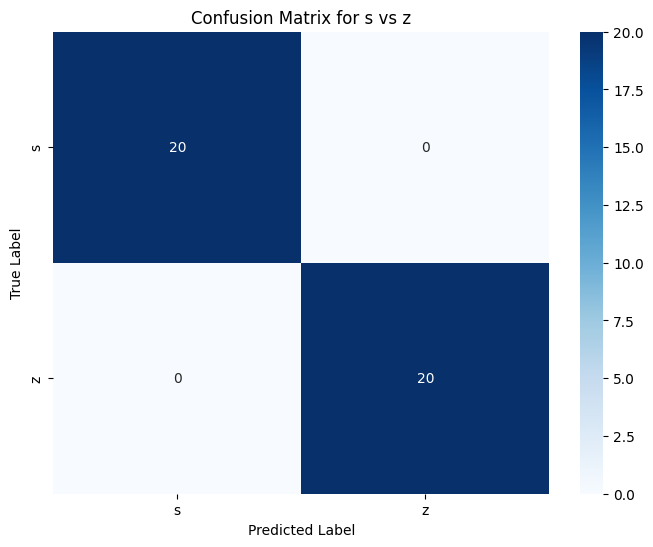

Label s: Loaded 409700 data points.
Label s: Created 100 segments.
Label o: Loaded 409700 data points.
Label o: Created 100 segments.
Total segments: 200
Total labels: 200
Cross-validation accuracy for s vs o: 0.95
Test accuracy for s vs o: 0.925
Confusion Matrix:
[[18  2]
 [ 1 19]]
Classification Report:
              precision    recall  f1-score   support

           o       0.95      0.90      0.92        20
           s       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



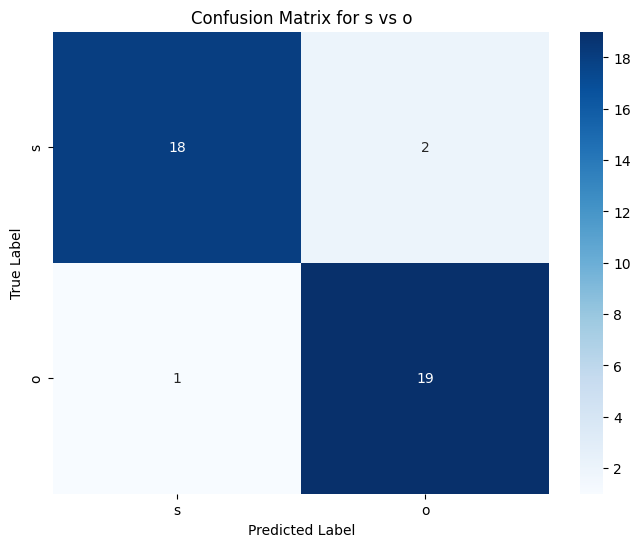

Label s: Loaded 409700 data points.
Label s: Created 100 segments.
Label f: Loaded 409700 data points.
Label f: Created 100 segments.
Total segments: 200
Total labels: 200
Cross-validation accuracy for s vs f: 0.8625
Test accuracy for s vs f: 0.9
Confusion Matrix:
[[17  3]
 [ 1 19]]
Classification Report:
              precision    recall  f1-score   support

           f       0.94      0.85      0.89        20
           s       0.86      0.95      0.90        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



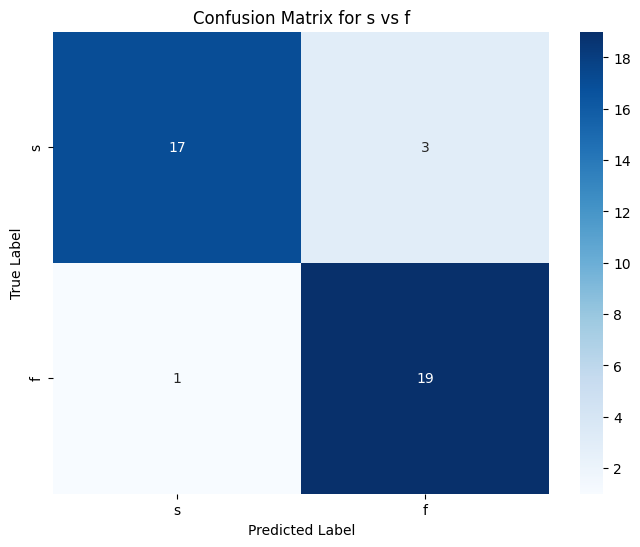

Label s: Loaded 409700 data points.
Label s: Created 100 segments.
Label n: Loaded 409700 data points.
Label n: Created 100 segments.
Total segments: 200
Total labels: 200
Cross-validation accuracy for s vs n: 0.93125
Test accuracy for s vs n: 0.875
Confusion Matrix:
[[17  3]
 [ 2 18]]
Classification Report:
              precision    recall  f1-score   support

           n       0.89      0.85      0.87        20
           s       0.86      0.90      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



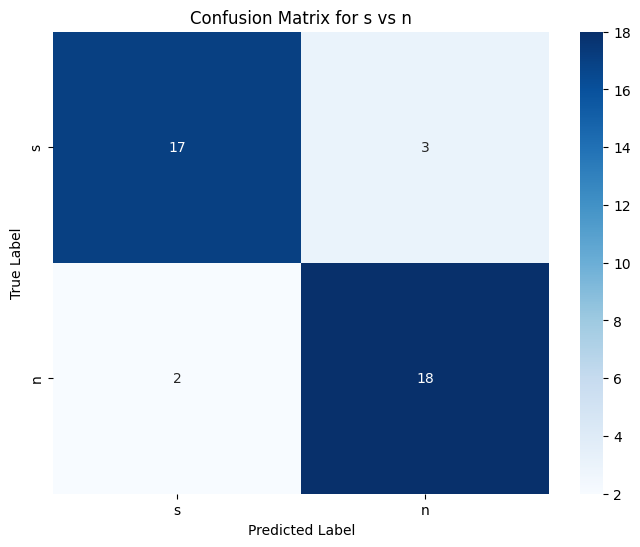

In [ ]:
import numpy as np
import os
from scipy.signal import butter, filtfilt, detrend
from scipy.linalg import toeplitz
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Base paths with labels
base_paths = {
    's': "/content/drive/MyDrive/Database/Bonn Univ Dataset/s/S/",
    'z': "/content/drive/MyDrive/Database/Bonn Univ Dataset/z/Z/",
    'o': "/content/drive/MyDrive/Database/Bonn Univ Dataset/o/O/",
    'f': "/content/drive/MyDrive/Database/Bonn Univ Dataset/f/F/",
    'n': "/content/drive/MyDrive/Database/Bonn Univ Dataset/n/N/"
}

# Function to load EEG data from specified directory
def load_eeg_data(base_path):
    eeg_data = []
    for file_name in os.listdir(base_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(base_path, file_name)
            data = np.loadtxt(file_path)
            eeg_data.append(data)
    if len(eeg_data) == 0:
        raise ValueError(f"No data found in directory: {base_path}")
    return np.concatenate(eeg_data)

# Function to preprocess EEG signal
def preprocess_signal(signal, lowcut=0.5, highcut=40, fs=173.61):
    signal_detrended = detrend(signal)
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    signal_filtered = filtfilt(b, a, signal_detrended)
    scaler = StandardScaler()
    signal_normalized = scaler.fit_transform(signal_filtered.reshape(-1, 1)).flatten()
    return signal_normalized

# Segment and preprocess data before splitting
segment_length = 4097  # 23.6 seconds * 173.61 Hz
def segment_and_preprocess(data, label):
    segments, labels = [], []
    for i in range(0, len(data), segment_length):
        segment = data[i:i+segment_length]
        if len(segment) == segment_length:
            segment = preprocess_signal(segment)
            segments.append(segment)
            labels.append(label)
    print(f"Label {label}: Created {len(segments)} segments.")
    return segments, labels

# Function to run binary classification for a given pair of classes
def run_binary_classification(class1, class2):
    all_segments, all_labels = [], []

    for label, path in [(class1, base_paths[class1]), (class2, base_paths[class2])]:
        eeg_data = load_eeg_data(path)
        print(f"Label {label}: Loaded {len(eeg_data)} data points.")
        segments, labels = segment_and_preprocess(eeg_data, label)
        all_segments.extend(segments)
        all_labels.extend(labels)

    # Check the number of segments and labels
    print(f'Total segments: {len(all_segments)}')
    print(f'Total labels: {len(all_labels)}')

    # Split data into training and testing sets
    if len(all_segments) > 0:
        test_size = 0.2 if len(all_segments) >= 5 else 0.1
        X_train, X_test, y_train, y_test = train_test_split(all_segments, all_labels, test_size=test_size, random_state=42, stratify=all_labels)

    # Feature extraction using Linear Predictive Coding (LPC)
    def lpc_features(segment, order=10):
        autocorr = np.correlate(segment, segment, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        R = toeplitz(autocorr[:order])
        r = autocorr[1:order+1]
        a = np.linalg.solve(R, -r)
        a = np.hstack([1, a])
        lpc_mean = np.mean(a)
        lpc_variance = np.var(a)
        lpc_skewness = skew(a)
        lpc_kurtosis = kurtosis(a)
        return np.concatenate([a, [lpc_mean, lpc_variance, lpc_skewness, lpc_kurtosis]])

    def extract_lpc_features(segments):
        return [lpc_features(segment) for segment in segments]

    X_train_features = extract_lpc_features(X_train)
    X_test_features = extract_lpc_features(X_test)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_features = imputer.fit_transform(X_train_features)
    X_test_features = imputer.transform(X_test_features)

    # Define classifiers
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

    # Voting classifier with majority voting
    voting_clf = VotingClassifier(estimators=[('rf', clf_rf), ('gb', clf_gb)], voting='soft')

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5)
    cross_val_scores = cross_val_score(voting_clf, X_train_features, y_train, cv=skf, scoring='accuracy')

    print(f'Cross-validation accuracy for {class1} vs {class2}: {np.mean(cross_val_scores)}')

    # Train the classifier
    voting_clf.fit(X_train_features, y_train)

    # Make predictions on test set
    y_pred = voting_clf.predict(X_test_features)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'Test accuracy for {class1} vs {class2}: {accuracy}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[class1, class2], yticklabels=[class1, class2])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {class1} vs {class2}')
    plt.show()

# Run binary classification for each pair
run_binary_classification('s', 'z')
run_binary_classification('s', 'o')
run_binary_classification('s', 'f')
run_binary_classification('s', 'n')
